In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

In [6]:
L = 2
#L = 50
#L = 100
#Generate some initial random grids of spins

In [82]:
#init_random
#lattice_n

In [11]:
init_random = np.random.random((L,L))
lattice_n = np.zeros((L, L))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

init_random = np.random.random((L,L))
lattice_p = np.zeros((L, L))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

In [13]:
lattice_n

array([[-1.,  1.],
       [-1., -1.]])

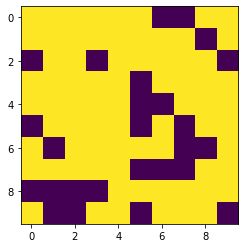

In [151]:
#Show initial lattice of spins
plt.imshow(lattice_p)
plt.savefig('Pictures/Lattice_p(L=10).png')

In [87]:
#kern = generate_binary_structure(2, 1) 
#kern[1][1] = False

In [88]:
#kern

In [155]:
#Function to get the energy 

def get_energy(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    return arr.sum()

In [156]:
get_energy(lattice_n)

-40.0

The metropolis algorithm:

1. Takes in initial 2d grid of spins, number of time steps to run algoritm for, and temperature BJ
2. Returns the total spin of all the atoms

In [157]:
import numpy as np
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        # 2. pick random point on array and flip spin
        x = np.random.randint(0,L)
        y = np.random.randint(0,L)
        spin_i = spin_arr[x,y] #initial spin
        spin_f = spin_i*-1 #proposed spin flip
        
        # compute change in energy
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<L-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<L-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
        # 3 / 4. change state with designated probabilities
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[t] = abs(spin_arr.mean()) #TAKE ABSOLUTELY VALUE AND THEN MEAN AVERAGE OF SPINS
        net_energy[t] = abs(energy)
    
    #net_spins = np.mean(net_spins[t])
    #net_energy = np.mean(net_energy[t])
            
    return net_spins, net_energy

C:\Users\USER\anaconda3\lib\site-packages\numba\core\decorators.py:260: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Get arrays of spins and energies throughout the dance (this is NOT representative of time evolution: its merely a tool used to reach equilibrium)

In [158]:
spins, energies = metropolis(lattice_n, 1000000, 1.7, get_energy(lattice_n))

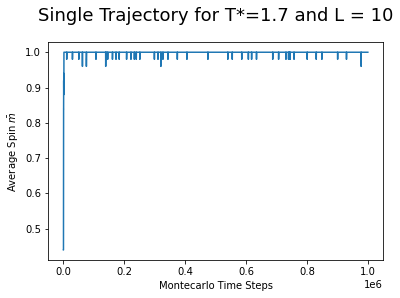

OSError: [Errno 22] Invalid argument: 'Pictures/(Single Trajectory for T*=1.7 and L = 10).png'

<Figure size 432x288 with 0 Axes>

In [163]:
import os 
plt.figsize=(12,4)
plt.plot(spins/L*L)
plt.xlabel('Montecarlo Time Steps')
plt.ylabel(r'Average Spin $\bar{m}$')
ax.grid()
fig.tight_layout()
plt.title(r'Single Trajectory for T*=1.7 and L = 10', y=1.07, size=18)
plt.show()
plt.savefig('Pictures/(Single Trajectory for T*=1.7 and L = 10).png')

In [138]:
def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(lattice, 1000000, bj, get_energy(lattice))
        ms[i] = abs(spins[-10000:]).mean()/L**2
        E_means[i] = abs(energies[-10000:]).mean()
        E_stds[i] = energies[-10000:].std()
    return ms, E_means, E_stds
    
BJs = np.arange(0.1, 2, 0.05)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

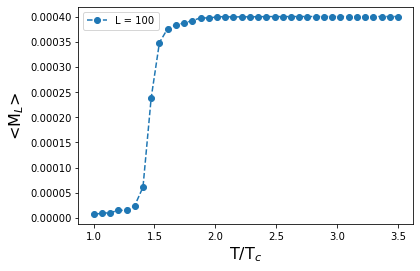

In [143]:
Ns = [10, 50, 100]  # System Size
T_Tcs = np.linspace(1.0, 3.5, 38)  # T/Tc
Tc = 2.268  # Onsager's Tc

for n in Ns:
    
    for i, T_Tc in enumerate(T_Tcs):
        T = T_Tc*Tc
        #spins, energies = metropolis(lattice, 1000000, bj, get_energy(lattice))
        #ms[i] = abs(spins[-10000:]).mean()/L**2
        
plt.plot(T_Tcs, ms_n, 'o--', label = 'L = {0}'.format(n))
   
plt.xlabel('T/T$_{c}$', fontsize = 16)
plt.ylabel('<M$_{L}$>', fontsize = 16)
plt.legend()
#plt.savefig('Pictures/magnetization2.png')
plt.show()

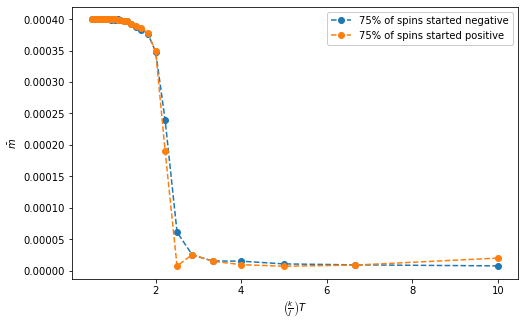

In [139]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

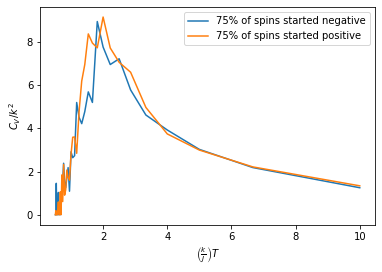

In [60]:
plt.plot(1/BJs, E_stds_n*BJs, label='75% of spins started negative')
plt.plot(1/BJs, E_stds_p*BJs, label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()